# NPLM Output Analysis

## Imports

In [7]:
import torch 
import h5py
import os 
import sys 
import json

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(0, "../src")
from plot_utils     import plot_ref_data, plot_ref_data_reco, plot_loss_history, plot_one_t, plot_two_t, plot_quantiles_evolution
from analysis_utils import compute_df, produce_bins, save_binning, load_binning, find_results, load_results, compute_t_from_loss
from nn_utils       import NPLMnetwork

## Config

In [8]:
hep.style.use(hep.style.CMS)

## Constants

In [9]:
OUTPUT_DIRECTORY = "../output/test/"

# Plotting parameters
FONTSIZE  = 36
FIGSIZE_R = (14, 12)
FIGSIZE   = (14, 10)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

## Config JSONs

In [10]:
#w_clip = 5
# json_path_ref  = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.0_Arch_1_4_1/2024_1_29_8_36_20_97375/config_2024_1_29_8_36_20_97375.json"
# json_path_data = "/home/ubuntu/NPLM.torch/output/test/wclip_test1/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.0_Arch_1_4_1/2024_1_26_17_18_52_646186/config_2024_1_26_17_18_52_646186.json"

# w_clip = 10
# json_path_ref  = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_10.0_Arch_1_4_1/2024_1_29_9_32_25_964095/config_2024_1_29_9_32_25_964095.json"
# json_path_data = "/home/ubuntu/NPLM.torch/output/test/wclip_test1/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_10.0_Arch_1_4_1/2024_1_26_18_15_19_94417/config_2024_1_26_18_15_19_94417.json"

# w_clip = 15 
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_15.0_Arch_1_4_1/2024_1_29_10_27_47_707642/config_2024_1_29_10_27_47_707642.json"

# w_clip = 20
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_20.0_Arch_1_4_1/2024_1_29_11_23_28_784271/config_2024_1_29_11_23_28_784271.json"

# w_clip = 25
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_25.0_Arch_1_4_1/2024_1_29_12_17_58_775129/config_2024_1_29_12_17_58_775129.json"

# w_clip = 30
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_30.0_Arch_1_4_1/2024_1_29_13_12_3_730011/config_2024_1_29_13_12_3_730011.json"


# with open(json_path_ref) as f:
#     config_json_ref = json.load(f)
# config_json_ref

In [11]:
json_path_ref  =   '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.0_Arch_1_4_1/2024_1_30_2_56_42_531698/config_2024_1_30_2_56_42_531698.json'

with open(json_path_ref) as f:
    config_json_ref = json.load(f)
config_json_ref

{'N_Ref': 200000,
 'N_Bkg': 2000,
 'N_Sig': 0,
 'SIG_LOC': 6.4,
 'SIG_STD': 0.16,
 'output_directory': '../output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.0_Arch_1_4_1/2024_1_30_2_56_42_531698/',
 'input_directory': './',
 'epochs': 200000,
 'patience': 5000,
 'architecture': [1, 4, 1],
 'weight_clipping': 6.0,
 'date': '2024_1_30_2_56_42_531698',
 'pyscript': 'toy.py',
 'toys': 40}

In [12]:
# config_json_data = {
#     "N_Ref": 200000,
#     "N_Bkg": 2000,
#     "N_Sig": 10,
#     "SIG_LOC": 6.4,
#     "SIG_STD": 0.16,
#     "output_directory": "./output/1D/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_9_Arch_1_4_1/2023_11_13_18_20_40_664973/",
#     "input_directory": "./",
#     "epochs": 200000,
#     "patience": 5000,
#     "architecture": [
#         1,
#         4,
#         1
#     ],
#     "weight_clipping": 9,
#     "date": "2023_11_13_18_20_40_664973",
#     "pyscript": "toy.py"
# }

# config_json_ref  = {
#     "N_Ref": 200000,
#     "N_Bkg": 2000,
#     "N_Sig": 0,
#     "SIG_LOC": 6.4,
#     "SIG_STD": 0.16,
#     "output_directory": "./output/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_9_Arch_1_4_1/2023_11_13_22_47_46_885226/",
#     "input_directory": "./",
#     "epochs": 200000,
#     "patience": 5000,
#     "architecture": [
#         1,
#         4,
#         1
#     ],
#     "weight_clipping": 9,
#     "date": "2023_11_13_22_47_46_885226",
#     "pyscript": "toy.py"
# }

## Load NPLM results

In [13]:
ref_dir  = config_json_ref["output_directory"]
# data_dir = config_json_data["output_directory"]

ref_losses_names   = find_results(ref_dir, "losses.pth")
ref_weights_names  = find_results(ref_dir, "weights.pth")
# data_losses_names  = find_results(data_dir, "losses.pth")
# data_weights_names = find_results(data_dir, "weights.pth")

ref_losses, ref_weights   = load_results(ref_dir, ref_losses_names, ref_weights_names)
# data_losses, data_weights = load_results(data_dir, data_losses_names, data_weights_names)

## Visualize NPLM results

### Compute test statistics from NPLM results

In [14]:
t_ref  = compute_t_from_loss(ref_losses)
# t_data = compute_t_from_loss(data_losses)

t_ref_final  = t_ref[:, -1]
# t_data_final = t_data[:, -1]

### Plot BKG only test statistics distribution

In [15]:
ref_dof  = compute_df(config_json_ref["architecture"])
ref_chi2 = stats.chi2(df=ref_dof)

In [16]:
t_ref_bins  = np.arange(0, 50, 2)
t_data_bins = np.arange(0, 80, 5)
xgrid_ref   = np.arange(0, 50, 0.5)
xgrid_data  = np.arange(0, 80, 0.5)

WEIGHT CLIPPING = 6.0


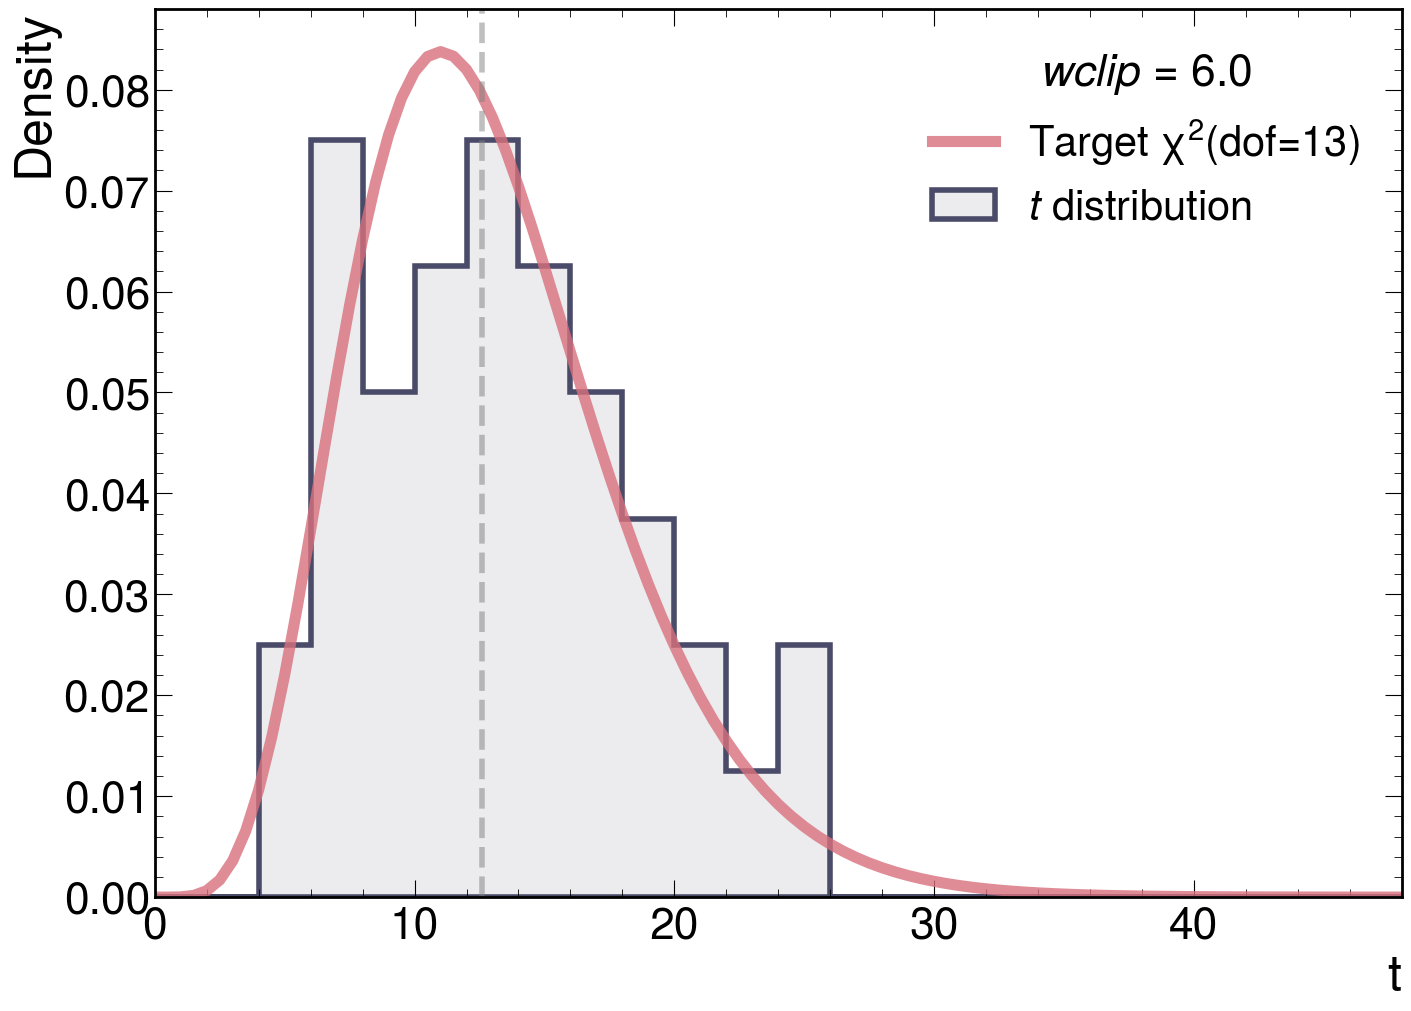

In [17]:
print(f'WEIGHT CLIPPING = {config_json_ref["weight_clipping"]}')
plot_one_t(
    t_distribution  = t_ref_final,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = (PALETTE_2[0], 1.0),
    hist_fcolor     = (PALETTE_2[0], 0.1),
    chi2_color      = (PALETTE_2[3], 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = config_json_ref["weight_clipping"],
)


### Compatibility $\mathcal{R}$ vs pseudo-$\mathcal{R}$

In [18]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_ref_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
# p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}\n')

cdf_values  = ref_chi2.cdf(xgrid_ref)
cdf_t_distr = np.cumsum(t_ref_final)

ks_statistic, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(13,))

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

p-value: 0.47836708440594067
Z-score: 0.7089313418853157

KS Statistic: 0.09001088928260637
P-value: 0.8733666385558663


### Plot BKG and BKG+SIG test statistics distributions

In [20]:
plot_two_t(
    t_distribution_1  = t_ref_final,
    t_bins_1          = t_ref_bins,
    t_distribution_2  = t_data_final,
    t_bins_2          = t_data_bins,
    chi2              = ref_chi2,
    chi2_grid         = xgrid_ref,
    show_error_1      = False,
    show_error_2      = False,
    show_hist_1       = True,
    show_hist_2       = True,
    compute_rate_1    = False,
    compute_rate_2    = True,
    err_marker_1      = "o",
    err_marker_2      = "o",
    err_markersize_1  = 10,
    err_markersize_2  = 10,
    err_capsize_1     = 5,
    err_capsize_2     = 5,
    err_elinewidth_1  = 4,
    err_elinewidth_2  = 4,
    err_capthick_1    = 4,
    err_capthick_2    = 4,
    figsize           = FIGSIZE,
    fontsize          = FONTSIZE,
    cms               = False,
    cms_label         = "",
    cms_rlabel        = "",
    hist_ecolor_1     = (PALETTE_2[0], 1),
    hist_ecolor_2     = (PALETTE_2[3], 1),
    hist_fcolor_1     = (PALETTE_2[0], 0.1),
    hist_fcolor_2     = (PALETTE_2[3], 0),
    err_ecolor_1      = (PALETTE_2[0], 1),
    err_ecolor_2      = (PALETTE_2[3], 1),
    chi2_color        = (PALETTE_2[0], 0.8),
    hist_lw_1         = 4,
    hist_lw_2         = 4,
    chi2_lw           = 8,
    hist_type_1       = "stepfilled",
    hist_type_2       = "stepfilled",
    hist_label_1      = "Reference $\it{t}$ distribution",
    hist_label_2      = "Observed $\it{t}$ distribution",
    chi2_label        = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel            = "$\it{t}$",
    ylabel            = "Density",
    show_plot         = True,
    save_plot         = False,
    plot_name         = "t_distribution",
    plot_path         = PLOT_PATH,
    plot_format       = "png",
    return_fig        = False
)

### Plot quantiles evolution over training

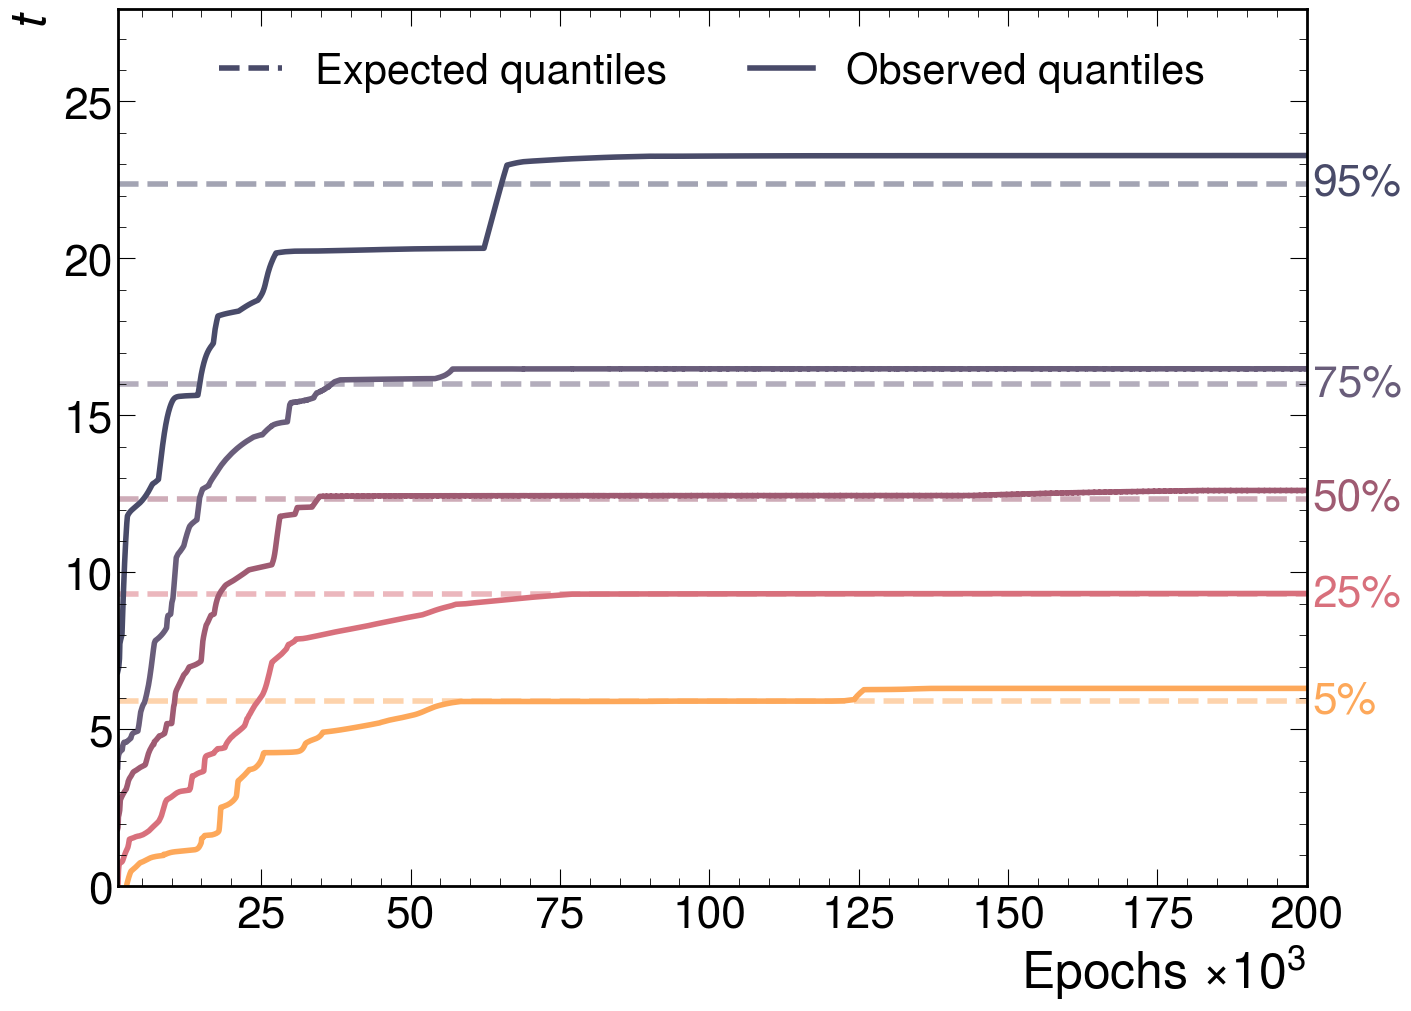

In [21]:
quantile_list   = [0.95,  0.75,  0.5,   0.25,  0.05]
quantile_labels = ["95%", "75%", "50%", "25%", "5%"]

plot_quantiles_evolution(
    t_history       = t_ref,
    quantile_list   = quantile_list,
    quantile_labels = quantile_labels,
    chi2            = ref_chi2,
    obs_alpha       = 1.0,
    th_alpha        = 0.5,
    epochs_init     = 1000,
    epochs_norm     = 1e3,
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    palette         = PALETTE_2,
    lw              = 4,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    grid            = False,
    xlabel          = r"Epochs $\times 10^3$",
    ylabel          = "$\it{t}$",
    show_plot       = True,
    save_plot       = True,
    plot_name       = "loss_history_w" + str({config_json_ref["weight_clipping"]}),
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    # plot_w          = True,
    # wclip           = config_json_ref["weight_clipping"],
)

### Compatibility $\mathcal{R}$ vs $\mathcal{D}$

In [24]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_data_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

print(p_val_def)
print(p_val)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}')

In [25]:
# value of t which is the quantile of 95%
np.quantile(t_data_final, (1-p_val))


## w clipping 

In [26]:
paths = find_results("/home/ubuntu/NPLM.torch/output/1D_w/second/1D/", ".json")

In [42]:
p = "/home/ubuntu/NPLM.torch/output/1D_w/second/1D/"
results = []
for folder in os.listdir(p):
    for ff in os.listdir(p+folder):
        for j in os.listdir(p+folder+"/"+ff):
            if j.endswith(".json"):
                results.append(p+folder+"/"+ff+"/"+j)

# results

In [55]:
# paths = ['/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_4.5_Arch_1_4_1/2024_1_29_19_33_23_669862/config_2024_1_29_19_33_23_669862.json',
#  '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.5_Arch_1_4_1/2024_1_30_0_28_6_595983/config_2024_1_30_0_28_6_595983.json',
#  '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.0_Arch_1_4_1/2024_1_30_2_56_42_531698/config_2024_1_30_2_56_42_531698.json',
#  '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.0_Arch_1_4_1/2024_1_29_22_0_53_376379/config_2024_1_29_22_0_53_376379.json',
#  '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_4.0_Arch_1_4_1/2024_1_29_17_4_5_7236/config_2024_1_29_17_4_5_7236.json',
#  '/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.5_Arch_1_4_1/2024_1_30_5_26_1_496748/config_2024_1_30_5_26_1_496748.json']

paths = [dir for dir in results if not "31.5" in dir]

ref_dirs= []; ref_losses_list=[]; ref_weights_list = []; t_ref_distrib = []
w_clips = []

for path in paths:
    with open(path) as f:
        config_json_ref = json.load(f)
        ref_dirs.append(config_json_ref["output_directory"])
        w_clips.append(config_json_ref["weight_clipping"])

data = list(zip(w_clips, ref_dirs))

# Ordina la lista in base ai valori di x
sorted_data = sorted(data, key=lambda tup: tup[0])

# Separa nuovamente le liste ordinate
w_clips, ref_dirs = zip(*sorted_data)

for dir in ref_dirs:
    l, w = load_results(dir, ref_losses_names, ref_weights_names)
    ref_losses_list.append(compute_t_from_loss(l))
    ref_weights_list.append(w)    

print("number of w clipping values: ", len(ref_losses_list))
print("number of toys per value: ", len(ref_losses_list[0]))
print("number of epochs, i.e. number of loss values(t): ", len(ref_losses_list[0][0]), "\n")

for t in ref_losses_list:
    t_ref_distrib.append(t[:,-1])

for w in range(len(w_clips)):
    ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[w], "chi2", args=(13,))
    print(f"KS Statistic for w={w_clips[w]} is : {ks_statistic}")
    print(f"P-value: {ks_p_value}\n")
    
    

number of w clipping values:  16
number of toys per value:  40
number of epochs, i.e. number of loss values(t):  200000 

KS Statistic for w=4.0 is : 0.18500575394854596
P-value: 0.11358711532503152

KS Statistic for w=4.5 is : 0.1770267818957182
P-value: 0.14418481903620795

KS Statistic for w=5.0 is : 0.11537012270388958
P-value: 0.6200292359223538

KS Statistic for w=5.5 is : 0.11802362726245752
P-value: 0.5917815013295727

KS Statistic for w=6.0 is : 0.09001088928260637
P-value: 0.8733666385558663

KS Statistic for w=6.5 is : 0.12025799629324438
P-value: 0.5682201035289027

KS Statistic for w=7.0 is : 0.07621034987522142
P-value: 0.9605210778163993

KS Statistic for w=7.5 is : 0.1618646242045514
P-value: 0.22023248981276633

KS Statistic for w=8.0 is : 0.24786536151015426
P-value: 0.011903503854026165

KS Statistic for w=8.5 is : 0.13779569111549433
P-value: 0.39715881857374213

KS Statistic for w=9.0 is : 0.11835533578952345
P-value: 0.5882685907911285

KS Statistic for w=29.0 is 

In [56]:
ks_stat = []
for i in range(len(w_clips)):
    if(w_clips[i]<10):
        ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[i], "chi2", args=(13,))
        ks_stat.append(ks_statistic)

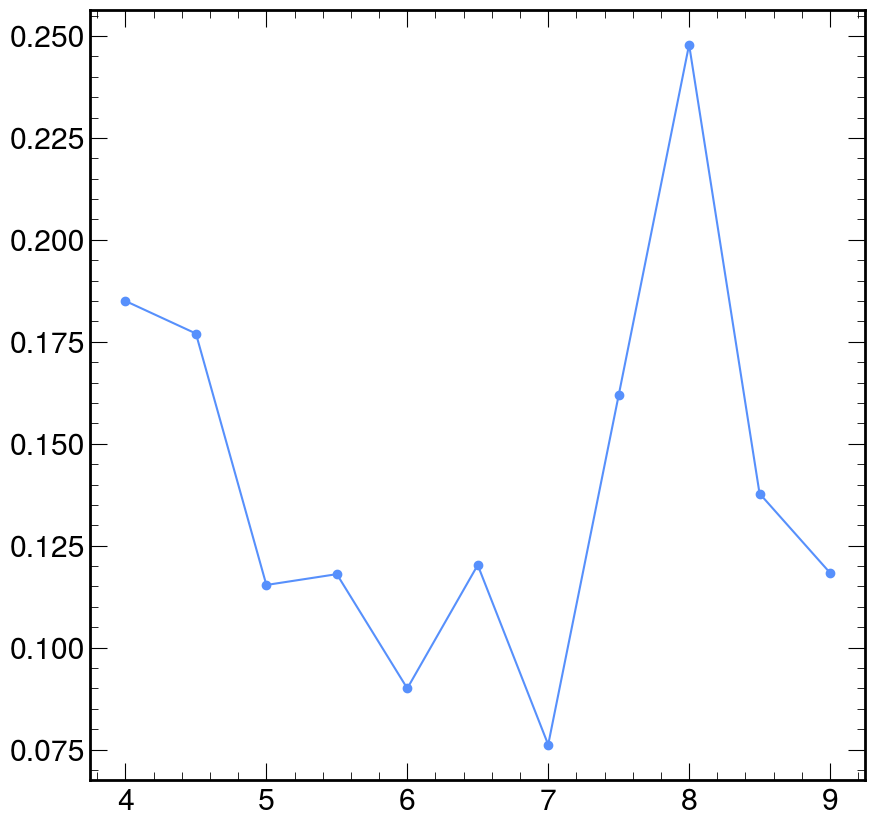

In [61]:
plt.plot([w for w in w_clips if w<10], ks_stat)
plt.scatter([w for w in w_clips if w<10], ks_stat)